# How to use polygons or lines as exposure

Exposure in CLIMADA are usually represented as individual points or a raster of points.
See [Exposures](climada_entity_Exposures.ipynb) tutorial to learn how to fill and use exposures.
In this tutorial we show you how to use CLIMADA Impf you have your exposure in the form of shapes/polygons or in the form of lines.

The approach follows three steps:
1. transform your polygon or line in a set of points
2. do the impact calculation in CLIMADA with that set of points
3. transform the calculated Impact back to your polygon or line

## Polygons
Polygons or shapes are a common geographical representation of countries, states etc. as for example in NaturalEarth. Here we want to show you how to deal with exposure information as polygons.

Lets assume we have the following data given. The polygons of the admin-1 regions of the netherlands and an exposure value each. We want to know the Impact of Lothar on each admin-1 region.

In [1]:
from cartopy.io import shapereader
from climada.entity.exposures.black_marble import country_iso_geom

# open the file containing the Netherlands admin-1 polygons
shp_file = shapereader.natural_earth(resolution='10m',
                                        category='cultural',
                                        name='admin_0_countries')
shp_file = shapereader.Reader(shp_file)

# extract the NL polygons
prov_names = {'Netherlands': ['Groningen', 'Drenthe',
                              'Overijssel', 'Gelderland', 
                                                'Limburg', 'Zeeland', 
                                                'Noord-Brabant', 'Zuid-Holland', 
                                                'Noord-Holland', 'Friesland', 
                                                'Flevoland', 'Utrecht']
                               }
polygon_Netherlands, polygons_prov_NL = country_iso_geom(prov_names,
                               shp_file)

# assign a value to each admin-1 area (assumption 100'000 USD per inhabitant)
population_prov_NL = {'Drenthe':493449, 'Flevoland':422202,
                 'Friesland':649988, 'Gelderland':2084478,
                 'Groningen':585881, 'Limburg':1118223,
                 'Noord-Brabant':2562566, 'Noord-Holland':2877909,
                 'Overijssel':1162215, 'Zuid-Holland':3705625,
                 'Utrecht':1353596, 'Zeeland':383689}
value_prov_NL = {n: 100000 * population_prov_NL[n] for n in population_prov_NL.keys()}


### Assume a unImpform distribution of values within your polygons
This helps you in the case you have a given total exposure value per polygon and we assume this value is distributed evenly within the polygon.

We can now perform the three steps for this example:

2021-04-23 15:35:35,789 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-04-23 15:35:35,790 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-04-23 15:35:35,791 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-04-23 15:35:35,792 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-04-23 15:35:35,793 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-04-23 15:35:35,808 - climada.util.coordinates - INFO - Setting geometry points.


/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:221: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']


2021-04-23 15:35:37,852 - climada.entity.exposures.base - INFO - category_id not set.
2021-04-23 15:35:37,853 - climada.entity.exposures.base - INFO - cover not set.
2021-04-23 15:35:37,853 - climada.entity.exposures.base - INFO - deductible not set.
2021-04-23 15:35:37,854 - climada.entity.exposures.base - INFO - region_id not set.
2021-04-23 15:35:37,854 - climada.entity.exposures.base - INFO - centr_ not set.


<GeoAxesSubplot:>

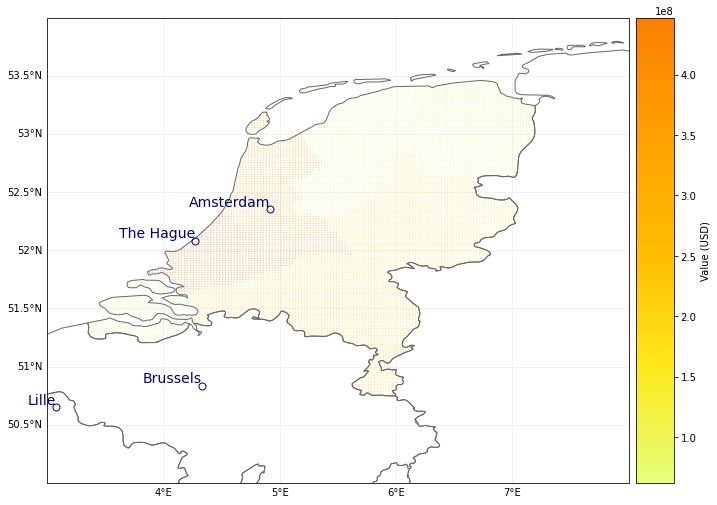

In [2]:
import numpy as np
from pandas import DataFrame
from climada.entity import Exposures
from climada.util.coordinates import coord_on_land


### 1. transform your polygon or line in a set of points
# create exposure with points
exp_df = DataFrame()
n_exp = 200*200
lat, lon = np.mgrid[50 : 54 : complex(0, np.sqrt(n_exp)),
                    3 : 8 : complex(0, np.sqrt(n_exp))]
exp_df['latitude'] = lat.flatten() # provide latitude
exp_df['longitude'] = lon.flatten() # provide longitude
exp_df['impf_WS'] = np.ones(n_exp, int) # provide impact functions 

# now we assign each point a province and a value, Impf the points are within one of the polygons defined above
exp_df['province'] = ''
exp_df['value'] = np.ones((exp_df.shape[0],))*np.nan
for prov_name_i, prob_polygon_i in zip(prov_names['Netherlands'],polygons_prov_NL['NLD']):
    in_geom = coord_on_land(lat=exp_df['latitude'], 
                                             lon=exp_df['longitude'],
                                             land_geom=prob_polygon_i)
    np.put(exp_df['province'].values, np.where(in_geom)[0], prov_name_i)
    np.put(exp_df['value'].values, np.where(in_geom)[0], value_prov_NL[prov_name_i]/sum(in_geom))

exp_df = Exposures(exp_df)
exp_df.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
exp_df.check()
exp_df.plot_hexbin()

2021-04-23 15:35:44,975 - climada.hazard.storm_europe - INFO - Constructing centroids from /Users/zeliestalhanske/climada/demo/data/fp_lothar_crop-test.nc
2021-04-23 15:35:45,005 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/zeliestalhanske/python_projects/climada_python/climada/hazard/centroids/centr.py:611: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


2021-04-23 15:35:47,493 - climada.hazard.storm_europe - INFO - Commencing to iterate over netCDF files.
2021-04-23 15:35:47,548 - climada.entity.exposures.base - INFO - Matching 40000 exposures with 9944 centroids.
2021-04-23 15:35:49,438 - climada.engine.impact - INFO - Calculating damage for 9660 assets (>0) and 2 events.


/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:190: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf = GeoDataFrame(*args, **kwargs)


<GeoAxesSubplot:>

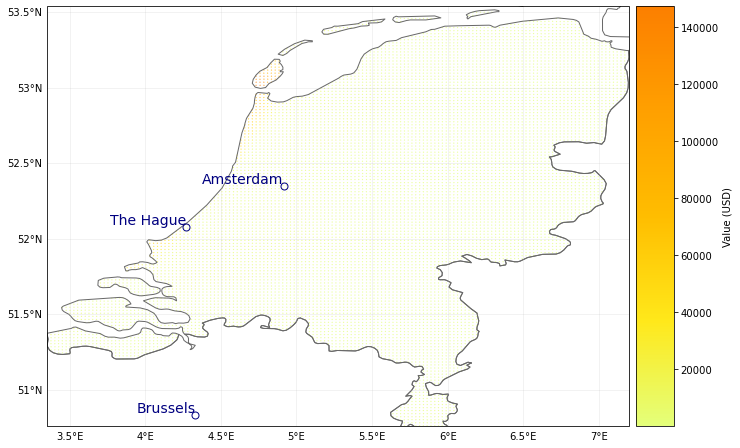

In [3]:
from climada.hazard.storm_europe import StormEurope
from climada.util.constants import WS_DEMO_NC
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs import ImpactFuncSet
from climada.engine import Impact

### 2. do the impact calculation in CLIMADA with that set of points
# define hazard
storms = StormEurope()
storms.read_footprints(WS_DEMO_NC, description='test_description')
# define impact function
impact_func = ImpfStormEurope()
impact_func.set_welker()
impact_function_set = ImpactFuncSet()
impact_function_set.append(impact_func)
# calculate hazard
impact_NL = Impact()
impact_NL.calc(exp_df, impact_function_set, storms, save_mat=True)
impact_NL.plot_hexbin_impact_exposure()

In [4]:
import pandas as pd

### 3. transform the calculated Impact back to your polygon or line
impact_at_province_raw = pd.DataFrame(np.mean(impact_NL.imp_mat.todense().transpose(), axis=1),
                                            index=exp_df.gdf['province'])
impact_at_province = impact_at_province_raw.groupby(impact_at_province_raw.index).sum()
print(impact_at_province)

                          0
province                   
               0.000000e+00
Drenthe        6.852537e+04
Flevoland      2.716078e+05
Friesland      7.782136e+05
Gelderland     4.056456e+05
Groningen      1.150089e+05
Limburg        2.559739e+05
Noord-Brabant  7.391625e+05
Noord-Holland  5.908293e+06
Overijssel     1.588620e+05
Utrecht        4.846288e+05
Zeeland        4.069767e+05
Zuid-Holland   2.893966e+06


### Use the LitPop module to disaggregate your exposure values

Instead of a unImpform distribution, another geographical distribution can be chosen to disaggregate within the value within each polygon. We show here the example of [LitPop](climada_entity_LitPop.ipynb). The same three steps apply:

2021-04-23 15:35:55,739 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-04-23 15:35:55,740 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-04-23 15:35:55,741 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-04-23 15:35:55,742 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-04-23 15:35:55,743 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326


/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:221: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']


2021-04-23 15:36:00,009 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 60 arcsec.
2021-04-23 15:36:11,914 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GPW population data: 2015
2021-04-23 15:36:11,915 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-04-23 15:36:43,165 - climada.entity.exposures.litpop - INFO - fin_mode=none --> no downscaling; admin1_calc is ignored
2021-04-23 15:36:43,166 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-04-23 15:36:43,166 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-04-23 15:36:43,167 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-04-23 15:36:43,167 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-04-23 15:36:43,175 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-0

/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:725: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  exp.gdf = GeoDataFrame(
/Users/zeliestalhanske/miniconda3/envs/climada_env/lib/python3.8/site-packages/geopandas/geodataframe.py:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)
/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:190: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf = GeoDataFrame(*args, **kwargs)


2021-04-23 15:36:43,929 - climada.util.coordinates - INFO - Setting geometry points.
2021-04-23 15:36:44,785 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2021-04-23 15:36:44,786 - climada.entity.exposures.base - INFO - category_id not set.
2021-04-23 15:36:44,787 - climada.entity.exposures.base - INFO - cover not set.
2021-04-23 15:36:44,787 - climada.entity.exposures.base - INFO - deductible not set.
2021-04-23 15:36:44,788 - climada.entity.exposures.base - INFO - centr_ not set.


<GeoAxesSubplot:title={'center':'LitPop for Netherlands at 60 as, year=2016, financial mode=none, GPW-\nyear=2015, BM-year=2016, exp=[1, 1]'}>

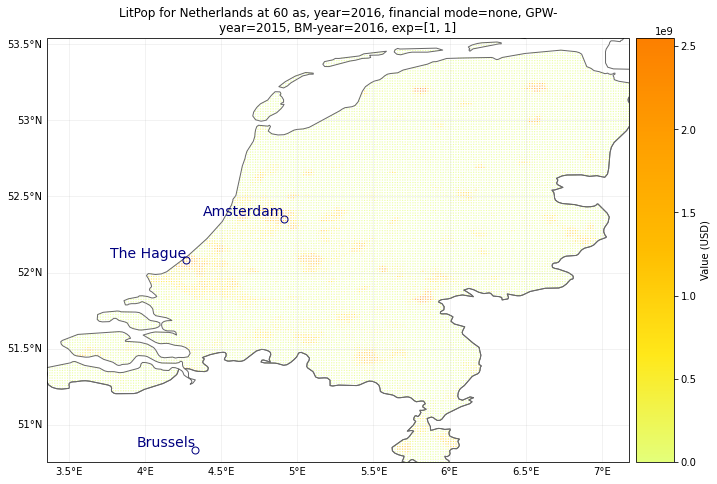

In [5]:
import numpy as np
from climada.entity import LitPop
from climada.util.coordinates import coord_on_land


### 1. transform your polygon or line in a set of points
# create exposure with points
exp_df_lp = LitPop()
exp_df_lp.set_country('Netherlands',res_arcsec = 60, fin_mode = 'none')
exp_df_lp.gdf['impf_WS'] = np.ones(exp_df_lp.gdf.shape[0], int) # provide impact functions 

# now we assign each point a province and a value, Impf the points are within one of the polygons defined above
exp_df_lp.gdf['province'] = ''
for prov_name_i, prob_polygon_i in zip(prov_names['Netherlands'],polygons_prov_NL['NLD']):
    in_geom = coord_on_land(lat=exp_df_lp.gdf['latitude'], 
                                             lon=exp_df_lp.gdf['longitude'],
                                             land_geom=prob_polygon_i)
    np.put(exp_df_lp.gdf['province'].values, np.where(in_geom)[0], prov_name_i)
    exp_df_lp.gdf['value'][np.where(in_geom)[0]] =  \
                exp_df_lp.gdf['value'][np.where(in_geom)[0]] * value_prov_NL[prov_name_i]/sum(exp_df_lp.gdf['value'][np.where(in_geom)[0]])
exp_df_lp.gdf = exp_df_lp.gdf.drop(np.where(exp_df_lp.gdf['province']=='')[0]) #drop carribean islands for this example
exp_df_lp.set_geometry_points()
exp_df_lp.check()
exp_df_lp.plot_hexbin()

2021-04-23 15:36:51,499 - climada.hazard.storm_europe - INFO - Constructing centroids from /Users/zeliestalhanske/climada/demo/data/fp_lothar_crop-test.nc
2021-04-23 15:36:51,529 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/zeliestalhanske/python_projects/climada_python/climada/hazard/centroids/centr.py:611: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


2021-04-23 15:36:53,597 - climada.hazard.storm_europe - INFO - Commencing to iterate over netCDF files.
2021-04-23 15:36:53,655 - climada.entity.exposures.base - INFO - Matching 17576 exposures with 9944 centroids.
2021-04-23 15:36:54,543 - climada.engine.impact - INFO - Calculating damage for 16834 assets (>0) and 2 events.


/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:190: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf = GeoDataFrame(*args, **kwargs)


<GeoAxesSubplot:>

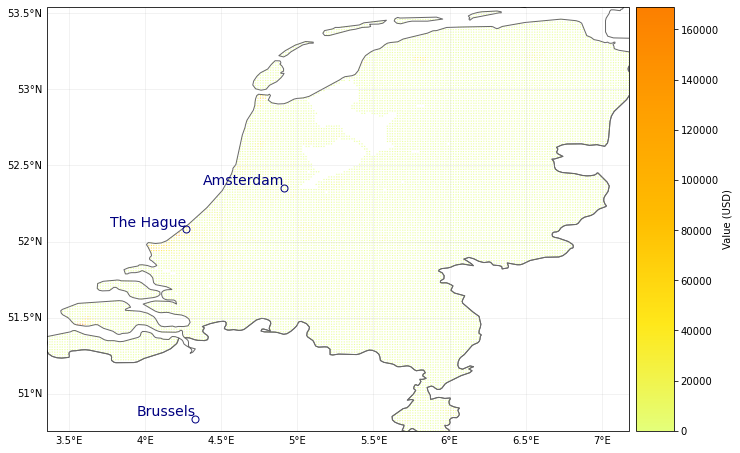

In [6]:
from climada.hazard.storm_europe import StormEurope
from climada.util.constants import WS_DEMO_NC
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs import ImpactFuncSet
from climada.engine import Impact

### 2. do the impact calculation in CLIMADA with that set of points
# define hazard
storms = StormEurope()
storms.read_footprints(WS_DEMO_NC, description='test_description')
# define impact function
impact_func = ImpfStormEurope()
impact_func.set_welker()
impact_function_set = ImpactFuncSet()
impact_function_set.append(impact_func)
# calculate hazard
impact_NL = Impact()
impact_NL.calc(exp_df_lp, impact_function_set, storms, save_mat=True)
impact_NL.plot_hexbin_impact_exposure()

In [7]:
import pandas as pd

### 3. transform the calculated Impact back to your polygon or line
impact_at_province_raw = pd.DataFrame(np.mean(impact_NL.imp_mat.todense().transpose(), axis=1),
                                            index=exp_df_lp.gdf['province'])
impact_at_province_lp = impact_at_province_raw.groupby(impact_at_province_raw.index).sum()
print(impact_at_province_lp)

                          0
province                   
Drenthe        6.397671e+04
Flevoland      1.666099e+05
Friesland      4.602394e+05
Gelderland     3.284452e+05
Groningen      1.563104e+05
Limburg        3.730663e+05
Noord-Brabant  6.247242e+05
Noord-Holland  1.819026e+06
Overijssel     1.074240e+05
Utrecht        4.484917e+05
Zeeland        7.632003e+05
Zuid-Holland   2.898284e+06


Comparison of both modelled impacts:

Text(0, 0.5, 'litpop disaggregation')

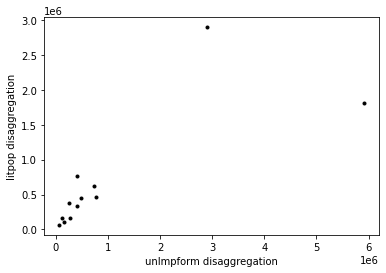

In [8]:
from matplotlib import pyplot as plt
plt.plot(impact_at_province[impact_at_province.index!=''],impact_at_province_lp, '.k')
plt.xlabel('unImpform disaggregation')
plt.ylabel('litpop disaggregation')

### Further statistical analysis of hazard on polygon level
imagine that you need access to the hazard centroids in oder to provide some statistical analysis on the province level

In [9]:
%%time
# this provides the wind speed value for each event at the corresponding exposure
import scipy

exp_df_lp.gdf[:5]
l1,l2,vals = scipy.sparse.find(storms.intensity)
exp_df_lp.gdf['wind_0']=0; exp_df_lp.gdf['wind_1']=0  # provide columns for both events
for evt,idx,val in zip(l1,l2,vals):
    if evt==0:
        exp_df_lp.gdf.loc[exp_df_lp.gdf.index[exp_df_lp.gdf['centr_WS']==idx],'wind_0']=val
    else:
        exp_df_lp.gdf.loc[exp_df_lp.gdf.index[exp_df_lp.gdf['centr_WS']==idx],'wind_1']=val

CPU times: user 10.6 s, sys: 92.3 ms, total: 10.7 s
Wall time: 10.8 s


Plot maximum wind per province for first event


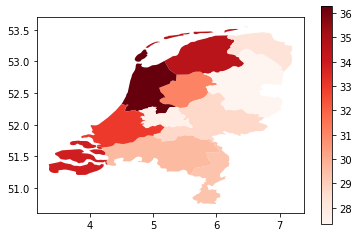

Plot mean wind per province for second event


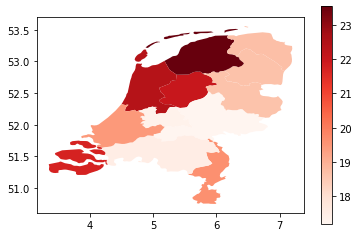

In [10]:
# now you can perform additional statistical analysis and aggregate it to the province level
import pandas as pd
import geopandas as gpd

exp_province_raw = exp_df_lp.copy()

def f(x):  # define function for statistical aggregation with pandas
    d = {}
    d['value'] = x['value'].sum()
    d['wind_0'] = x['wind_0'].max()
    d['wind_1'] = x['wind_1'].mean()
    # one could also be interested in centroid of max wind with respect to province
    #d['centr_WS'] = x.loc[x.index[x['wind_0'].max()],'centr_WS']  
    return pd.Series(d, index=['value', 'wind_0', 'wind_1'])

exp_province = exp_province_raw.gdf.groupby('province').apply(f).reset_index()  # Result is not a GeoDataFrame anymore
# add geometries to DataFrame and plot results 
exp_province=gpd.GeoDataFrame(exp_province, geometry=None)
for prov,poly in zip(list(prov_names.values())[0],polygons_prov_NL['NLD']):
    exp_province.loc[exp_province.index[exp_province['province']== prov],'geometry']= gpd.GeoDataFrame(geometry=[poly]).geometry.values
exp_province
print('Plot maximum wind per province for first event')
exp_province.plot(column='wind_0', cmap='Reds', legend=True)
plt.show()
print('Plot mean wind per province for second event')
exp_province.plot(column='wind_1', cmap='Reds', legend=True)
plt.show()

## Lines
Lines are common geographical representation of transport infrastructure like streets, train tracks or powerlines etc.

In [11]:
# under construction. here follows an example on how to deal with lines